In [210]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [211]:
# データの読込
train = pd.read_csv("../data/train_data.csv")
test = pd.read_csv('../data/test_data.csv')

# データの確認

In [212]:
def inspection_datas(df):
    print('######################################')
    print('①サイズ（行数、列数）の確認')
    print(df.shape)
    print('######################################')
    print('②最初の５行の表示')
    display(df.head())
    print('######################################')
    print('③各行のデータ型の確認（オブジェクト型の有無）')
    display(df.info())
    display(df.select_dtypes(include=object).columns)
    print('######################################')
    print('④各種統計値の確認（③で、Objectのものは統計されない）')
    display(df.describe())
    print('######################################')
    print('➄欠損値がある列の確認')
    null_df =df.isnull().sum()[df.columns[df.isnull().sum()!=0]]
    display(null_df)
    display(null_df.shape)
    print('######################################')
    print('⑥相関係数のヒートマップ')
    sns.heatmap(df.corr())

######################################
①サイズ（行数、列数）の確認
(66125, 32)
######################################
②最初の５行の表示


,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
0,1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,...,hokusai_becchu,NaN,26.0,herocharger_replica,NaN,68.0,sharp_neo,NaN,31.0,1
1,2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0
3,4,2019-11-11T14:00:00+00:00,5.0.1,regular,standard,nawabari,engawa,bamboo14mk1,NaN,336,...,liter4k,NaN,189.0,promodeler_mg,NaN,194.0,hotblaster_custom,NaN,391.0,0
4,5,2019-12-14T06:00:00+00:00,5.0.1,gachi,standard,hoko,chozame,bold_7,x,299,...,sputtery_hue,x,45.0,bucketslosher_soda,x,246.0,wakaba,x,160.0,1


######################################
③各行のデータ型の確認（オブジェクト型の有無）
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66125 entries, 0 to 66124
Data columns (total 32 columns):
id            66125 non-null int64
period        66125 non-null object
game-ver      66125 non-null object
lobby-mode    66125 non-null object
lobby         66125 non-null object
mode          66125 non-null object
stage         66125 non-null object
A1-weapon     66125 non-null object
A1-rank       51681 non-null object
A1-level      66125 non-null int64
A2-weapon     66125 non-null object
A2-rank       51681 non-null object
A2-level      66125 non-null float64
A3-weapon     66125 non-null object
A3-rank       51681 non-null object
A3-level      66125 non-null float64
A4-weapon     66074 non-null object
A4-rank       51638 non-null object
A4-level      66074 non-null float64
B1-weapon     66125 non-null object
B1-rank       51681 non-null object
B1-level      66125 non-null int64
B2-weapon     66125 non-null object


None

Index(['period', 'game-ver', 'lobby-mode', 'lobby', 'mode', 'stage',
       'A1-weapon', 'A1-rank', 'A2-weapon', 'A2-rank', 'A3-weapon', 'A3-rank',
       'A4-weapon', 'A4-rank', 'B1-weapon', 'B1-rank', 'B2-weapon', 'B2-rank',
       'B3-weapon', 'B3-rank', 'B4-weapon', 'B4-rank'],
      dtype='object')

######################################
④各種統計値の確認（③で、Objectのものは統計されない）


,id,A1-level,A2-level,A3-level,A4-level,B1-level,B2-level,B3-level,B4-level,y
count,66125.000000,66125.000000,66125.000000,66125.000000,66074.000000,66125.000000,66125.000000,66124.000000,66058.000000,66125.000000
mean,33063.000000,208.838926,155.351698,153.175229,156.001619,156.378722,152.764749,153.105393,157.869736,0.524703
std,19088.787612,118.986528,96.183950,95.470733,95.524571,97.109501,95.373534,94.891705,95.777647,0.499393
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,16532.000000,120.000000,82.000000,80.000000,84.000000,83.000000,80.000000,81.000000,86.000000,0.000000
50%,33063.000000,188.000000,139.000000,137.000000,140.000000,139.000000,136.000000,137.000000,142.000000,1.000000
75%,49594.000000,277.000000,208.000000,205.000000,208.000000,210.000000,205.000000,205.000000,212.000000,1.000000
max,66125.000000,585.000000,913.000000,920.000000,931.000000,920.000000,913.000000,933.000000,936.000000,1.000000


######################################
➄欠損値がある列の確認


A1-rank      14444
A2-rank      14444
A3-rank      14444
A4-weapon       51
A4-rank      14487
A4-level        51
B1-rank      14444
B2-rank      14444
B3-weapon        1
B3-rank      14444
B3-level         1
B4-weapon       67
B4-rank      14501
B4-level        67
dtype: int64

(14,)

######################################
⑥相関係数のヒートマップ


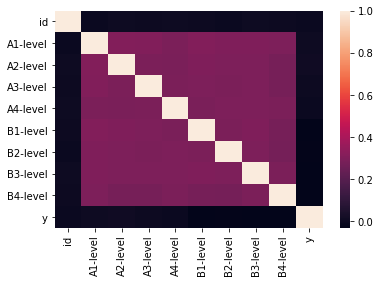

In [213]:
inspection_datas(train)

# 前処理

In [214]:
# 欠損値埋める
def fill_all_null(df, num):
    for col_name in df.columns[df.isnull().sum()!=0]:
        df[col_name] = df[col_name].fillna(num)

In [215]:
# 訓練データ、テストデータの欠損値を-1で補完
fill_all_null(train, -1)
fill_all_null(test, -1)

In [216]:
# ターゲットエンコーディングの関数定義
## Holdout TSを用いる 変更の余地あり
def change_to_target2(train_df,test_df,input_column_name,output_column_name):
    from sklearn.model_selection import KFold
    
    # nan埋め処理
    ## 上でやってるのでいらない
    # train_df[input_column_name] = train_df[input_column_name].fillna('-1')
    # test_df[input_column_name] = test_df[input_column_name].fillna('-1')

    kf = KFold(n_splits=5, shuffle=True, random_state=71)
    #=========================================================#
    c=input_column_name
    # 学習データ全体で各カテゴリにおけるyの平均を計算
    data_tmp = pd.DataFrame({c: train_df[c],'target':train_df['y']})
    target_mean = data_tmp.groupby(c)['target'].mean()
    #テストデータのカテゴリを置換★
    test_df[output_column_name] = test_df[c].map(target_mean)
    
    # 変換後の値を格納する配列を準備
    tmp = np.repeat(np.nan, train_df.shape[0])

    for i, (train_index, test_index) in enumerate(kf.split(train_df)): # NFOLDS回まわる
        #学習データについて、各カテゴリにおける目的変数の平均を計算
        target_mean = data_tmp.iloc[train_index].groupby(c)['target'].mean()
        #バリデーションデータについて、変換後の値を一時配列に格納
        tmp[test_index] = train_df[c].iloc[test_index].map(target_mean) 

    #変換後のデータで元の変数を置換
    train_df[output_column_name] = tmp
#========================================================#   


In [217]:
# オブジェクトの列のリストを作成
object_col_list = train.select_dtypes(include=object).columns
# オブジェクトの列は全てターゲットエンコーディング実施
for col in object_col_list:
    change_to_target2(train,test,col,"enc_"+col)
#　変換前の列を削除
train = train.drop(object_col_list,axis=1)
test = test.drop(object_col_list,axis=1)
#　'id'の列を削除
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

In [218]:
#　訓練データ欠損確認
train.isnull().sum().sum()

12

In [219]:
#　テストデータ欠損確認
test.isnull().sum().sum()

2

In [220]:
# 欠損値はターゲットエンコーディング時に学習データが少なくなって平均値が計算できなくなってしまうため発生。0埋め。
fill_all_null(train, 0)
fill_all_null(test, 0)

# データの確認

In [221]:
# 訓練データとテストデータの列を確認
print(train.columns)
print(test.columns)

Index(['A1-level', 'A2-level', 'A3-level', 'A4-level', 'B1-level', 'B2-level',
       'B3-level', 'B4-level', 'y', 'enc_period', 'enc_game-ver',
       'enc_lobby-mode', 'enc_lobby', 'enc_mode', 'enc_stage', 'enc_A1-weapon',
       'enc_A1-rank', 'enc_A2-weapon', 'enc_A2-rank', 'enc_A3-weapon',
       'enc_A3-rank', 'enc_A4-weapon', 'enc_A4-rank', 'enc_B1-weapon',
       'enc_B1-rank', 'enc_B2-weapon', 'enc_B2-rank', 'enc_B3-weapon',
       'enc_B3-rank', 'enc_B4-weapon', 'enc_B4-rank'],
      dtype='object')
Index(['A1-level', 'A2-level', 'A3-level', 'A4-level', 'B1-level', 'B2-level',
       'B3-level', 'B4-level', 'enc_period', 'enc_game-ver', 'enc_lobby-mode',
       'enc_lobby', 'enc_mode', 'enc_stage', 'enc_A1-weapon', 'enc_A1-rank',
       'enc_A2-weapon', 'enc_A2-rank', 'enc_A3-weapon', 'enc_A3-rank',
       'enc_A4-weapon', 'enc_A4-rank', 'enc_B1-weapon', 'enc_B1-rank',
       'enc_B2-weapon', 'enc_B2-rank', 'enc_B3-weapon', 'enc_B3-rank',
       'enc_B4-weapon', 'enc_B4-rank'

# 学習の準備

In [222]:
# 訓練データを説明変数と目的変数に分割
target = train['y']
train_x = train.drop('y',axis=1)
# LGBMのパラメータを設定
params = {
    # 二値分類問題
    'objective': 'binary',
    # 損失関数は二値のlogloss
    #'metric': 'auc',
    'metric': 'binary_logloss',
    # 最大イテレーション回数指定
    'num_iterations' : 1000,
    # early_stopping 回数指定
    'early_stopping_rounds' : 100,
}

# 学習・予測の実行

In [223]:
# k-分割交差検証を使って学習＆予測（K=10）
FOLD_NUM = 10
kf = KFold(n_splits=FOLD_NUM,
              random_state=42)
#lgbmのラウンド数を定義
num_round = 10000

In [224]:
#検証時のスコアを初期化
scores = []

#テストデータの予測値を初期化
pred_cv = np.zeros(len(test.index))


for i, (tdx, vdx) in enumerate(kf.split(train_x, target)):
    print(f'Fold : {i}')
    # 訓練用データと検証用データに分割
    X_train, X_valid, y_train, y_valid = train_x.iloc[tdx], train_x.iloc[vdx], target.values[tdx], target.values[vdx]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    # 学習の実行
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                      valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=100)

    # 検証データに対する予測値を求めて、勝敗（０　or　１）に変換
    va_pred = np.round(model.predict(X_valid,num_iteration=model.best_iteration))
    
    # accuracyスコアを計算
    score_ = accuracy_score(y_valid, va_pred)
    
    # フォールド毎の検証時のスコアを格納
    scores.append(score_)
    
    #テストデータに対する予測値を求める
    submission = model.predict(test,num_iteration=model.best_iteration)
    
    #テストデータに対する予測値をフォールド数で割って蓄積
    #(フォールド毎の予測値の平均値を求めることと同じ)
    pred_cv += submission/FOLD_NUM

# 最終的なテストデータに対する予測値を勝敗（０　or　１）に変換
pred_cv_int = np.round(pred_cv)

# 最終的なaccuracyスコアを平均値で出力
print('')
print('################################')
print('CV_score:'+ str(np.mean(scores)))

Fold : 0
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.644702	valid's binary_logloss: 0.684698
Early stopping, best iteration is:
[65]	train's binary_logloss: 0.657137	valid's binary_logloss: 0.684139
Fold : 1
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.644776	valid's binary_logloss: 0.683363
Early stopping, best iteration is:
[43]	train's binary_logloss: 0.665449	valid's binary_logloss: 0.683229
Fold : 2
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.644349	valid's binary_logloss: 0.684731
Early stopping, best iteration is:
[69]	train's binary_logloss: 0.655503	valid's binary_logloss: 0.684279
Fold : 3
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.644711	valid's binary_logloss: 0.687954
Early stopping, best iteration is:
[28]	train's binary_logloss: 0.672176	valid's binary_logloss: 0.686551


In [225]:
# 提出用ファイルを作成する
pd.DataFrame({"id": range(len(pred_cv_int)), "y": pred_cv_int.astype(np.int64) }).to_csv("submission_v0.1.csv", index=False)